### A3C Actor Critic

Implementation of the A3C Actor Critic algorithm, borrowing some ideas from:

1) [Asynchronous](https://github.com/awjuliani/DeepRL-Agents/blob/master/A3C-Doom.ipynb) Master-Worker architecture with threads, and overall program structure. [Blog](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2).

2) Flappy Bird [game](https://github.com/shalabhsingh/A3C_Keras_FlappyBird/blob/master/train_network.py) and image processing. [Blog](https://shalabhsingh.github.io/Deep-RL-Flappy-Bird/).

3) Episode Processing and Training in each Worker with [Keras](https://keras.io/examples/rl/actor_critic_cartpole/) 2.0

4) [Tensorboard](https://github.com/awjuliani/DeepRL-Agents/blob/master/A3C-Doom.ipynb) Integration and [visualising](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic) game screens

The Flappy Bird game [implementation](https://github.com/yanpanlau/Keras-FlappyBird) is explained in this [blog](https://yanpanlau.github.io/2016/07/10/FlappyBird-Keras.html)


#### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
%%bash
# !!!!!!!!!!!!! TEMPORARY !!!!!!!!
# Because of some install error with xvfb
sudo apt-get update

In [ ]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install -q pyvirtualdisplay > /dev/null 2>&1
pip install -q git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
import IPython.core.debugger as db

import sys
import threading
import multiprocessing
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from time import sleep
from collections import deque # Ordered collection with ends

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Convolution2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

#### Flappy Bird Game

To test with a different game, install it and modify the following classes:
* Environment
* StackFrame for preprocessing needed for the game's state data and
* ActorCritic for a model suited to the game's state data

In [ ]:
%%bash
# Install Flappy Bird game implementation which uses pygame framework
python -m pip install pygame
git clone https://github.com/yanpanlau/Keras-FlappyBird.git

In [ ]:
# Modify one Flappy Bird file (flappy_bird_utils.py) to disable sound processing
# by commenting out these lines:
#    #SOUNDS['die']    = pygame.mixer.Sound('assets/audio/die' + soundExt)
#    #SOUNDS['hit']    = pygame.mixer.Sound('assets/audio/hit' + soundExt)
#    #SOUNDS['point']  = pygame.mixer.Sound('assets/audio/point' + soundExt)
#    #SOUNDS['swoosh'] = pygame.mixer.Sound('assets/audio/swoosh' + soundExt)
#    #SOUNDS['wing']   = pygame.mixer.Sound('assets/audio/wing' + soundExt)

# Upload the modified file
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Replace the original Flappy Bird file with the modified one
!mv Keras-FlappyBird/game/flappy_bird_utils.py Keras-FlappyBird/game/old_flappy_bird_utils.py
!mv flappy_bird_utils.py Keras-FlappyBird/game

In [ ]:
import pygame

# Turn off the video display for the game
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Change the current directory to the Flappy Bird and add the code directory
# to the class path, so that it can be imported and loaded.
#sys.path.append("Keras-FlappyBird/game/")
os.chdir("/content/Keras-FlappyBird")
os.getcwd()
sys.path.append("./game/")
import wrapped_flappy_bird as game

Game Environment

In [ ]:
#----------------------------------------------------
# Environment object to wrap the playing of the game
#----------------------------------------------------
class Environment():
  def __init__(self, frame_w, frame_h, vis):
    self.game_state, self.actions = self._create()

    self.frame_w, self.frame_h = frame_w, frame_h
    stack_size = 4 # We stack 4 composite frames
    self.sf = StackFrame(stack_size, frame_w, frame_h)

    # For visualisation
    self.vis = vis

  # ----------------------------
  # Initialise the game
  # ----------------------------
  def _create(self):
    game_state = game.GameState()
    # Only two actions are possible
    actions = [[0,1], [1,0]]
    return game_state, actions

  # ----------------------------
  # Take one step by executing an action from the current state. Prepare a stacked
  # frame for the next state using the frame returned by the game.
  #
  # Return the stacked frame for the next state, the reward and a flag if we are in the
  # terminal state
  # ----------------------------
  def step(self, action, is_new_episode=False):
    next_frame, reward, done = self.game_state.frame_step(action)

    if (False):
      # For debugging
      print ('Action, reward, done', action, reward, done)
      self.sf.show_frame(next_frame)

    if (not done):
      # Episode isn't over so process the next frame
      next_preprocessed_frame = self.sf.preprocess(next_frame)
      next_stacked_state = self.sf.combine_prev(next_preprocessed_frame, is_new_episode)
      if (self.vis): self.vis.track_frame(next_frame)
    else:
      # We're at the terminal state, so use an empty stack for the next state
      next_stacked_state = self.sf.blank_stack()
      if (self.vis): self.vis.end_episode()

    next_stacked_state = tf.convert_to_tensor(next_stacked_state)
    return (next_stacked_state, reward, done)

  # ----------------------------
  # Get the first state at the beginning of the episode
  # ----------------------------
  def first_step(self, i_episode):
    if (self.vis): self.vis.begin_episode(i_episode)

    # get the first state by taking an action that does nothing
    do_nothing = np.zeros(len(self.actions))
    do_nothing[0] = 1

    next_stacked_state, _, _ = self.step(do_nothing, is_new_episode=True)
    return next_stacked_state

Stacked Frame

In [ ]:
import skimage as skimage
from skimage import transform, color, exposure

#----------------------------------------------------
# Processes the frame image which the game environment returns as the next state.
# Some basic image pre-processing is done on this frame. It is then stacked with
# the N previous frames for the preceding states to provide some  context about 
# motion and velocity of objects in the image.
#----------------------------------------------------
class StackFrame():
  def __init__(self, stack_sz, frame_w, frame_h):
    self.stack_sz = stack_sz  # How many previous frames to stack together 
    self.frame_w, self.frame_h = frame_w, frame_h

    self.init_stack()

  # ----------------------------
  # Create a stack as a deque to store the 'stack_sz' most recent frames. As each new 
  # frame is received it gets appended to the deque and pushes out the oldest frame.
  # ----------------------------
  def init_stack(self):
    stack_sz = self.stack_sz
    frame_w, frame_h = self.frame_w, self.frame_h

    # Initialize deque with zero-images, one array for each image
    self.stacked_frames = deque([np.zeros((frame_w, frame_h), dtype=np.int) for _ in range(stack_sz)], maxlen=stack_sz)

  # ----------------------------
  # Image pre-processing on the frame
  # ----------------------------
  def preprocess(self, frame):
    # Convert to grey scale
    grey_frame = skimage.color.rgb2gray(frame)

    # Resize and scale pixel intensity
    resized_frame = skimage.transform.resize(grey_frame, (self.frame_w, self.frame_h))
    rescaled_frame = skimage.exposure.rescale_intensity(resized_frame, out_range=(0,255))

    # Normalize Pixel Values
    normalized_frame = rescaled_frame / 255.0
      
    return normalized_frame

  #-----------------------------------------------------------------
  # We feed the last four frames to the Q Network, by stacking them with shape
  # (frame_w, frame_h, 4). The previous frames allows the network to reason about
  # motion of objects.
  #
  # Due to the way that Atari renders screens, every other frame may not actually be rendered.
  # This negatively affects our performance, so we take Deepmind's approach of 
  # taking the elementwise-maxima of the last two frames
  #-----------------------------------------------------------------
  def combine_prev(self, preprocessed_frame, is_new_episode):    
    if is_new_episode:
      # Clear our stacked_frames
      self.init_stack()
          
      # Because we're in a new episode, copy the same frame 4x, apply element-wise maxima
      maxframe = np.maximum(preprocessed_frame, preprocessed_frame)
      self.stacked_frames.append(maxframe)
      self.stacked_frames.append(maxframe)
      self.stacked_frames.append(maxframe)
      self.stacked_frames.append(maxframe)
          
    else:
      #Since deque append to right, we can fetch the previous frame
      maxframe=np.maximum(self.stacked_frames[-1], preprocessed_frame)
          
      # Append frame to deque, automatically removes the oldest frame
      self.stacked_frames.append(maxframe)
            
    # Stack the frames
    stacked_state = np.stack(self.stacked_frames, axis=2)
    # Add a batch dimension, with a batch size of 1
    stacked_state = stacked_state[np.newaxis, ...]
    
    return stacked_state

  # ----------------------------
  # Stack with blank frames
  # ----------------------------
  def blank_stack(self):
    return np.zeros((1, self.frame_w, self.frame_h, 4))

  # ----------------------------
  # Display a frame
  # ----------------------------
  def show_frame(self, frame):
    print(frame.shape)
    plt.imshow(frame)
    plt.show()

Actor Critic Model

In [ ]:
#----------------------------------------------------
# Actor Critic model, with some common layers containing a standard CNN architecture 
# followed by separate heads for the Actor and Critic
#----------------------------------------------------
class ActorCritic():
  def __init__(self, frame_rows, frame_cols):
    self.model = self._create(frame_rows, frame_cols)

  # ----------------------------
  # Create a model
  # ----------------------------
  def _create(self, frame_rows, frame_cols, frame_depth=4):
    model = Sequential()
    keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=None)

    S = Input(shape = (frame_rows, frame_cols, frame_depth, ), name = 'Input')
    h0 = Convolution2D(16, kernel_size = (8,8), strides = (4,4), activation = 'relu', kernel_initializer = 'random_uniform', bias_initializer = 'random_uniform')(S)
    h1 = Convolution2D(32, kernel_size = (4,4), strides = (2,2), activation = 'relu', kernel_initializer = 'random_uniform', bias_initializer = 'random_uniform')(h0)
    h2 = Flatten()(h1)
    h3 = Dense(256, activation = 'relu', kernel_initializer = 'random_uniform', bias_initializer = 'random_uniform') (h2)
    P = Dense(2, name = 'o_P', activation = 'softmax', kernel_initializer = 'random_uniform', bias_initializer = 'random_uniform') (h3)
    V = Dense(1, name = 'o_V', kernel_initializer = 'random_uniform', bias_initializer = 'random_uniform') (h3)

    model = Model(inputs = S, outputs = [P,V])
    #rms = RMSprop(lr = LEARNING_RATE, rho = 0.99, epsilon = 0.1)
    #model.compile(loss = {'o_P': logloss, 'o_V': sumofsquares}, loss_weights = {'o_P': 1., 'o_V' : 0.5}, optimizer = rms)
    return model
   
  # ----------------------------
  # Copy weights from one identical model to another. Used to copy weights from
  # the Master to the Worker Actor Critic networks.
  # ----------------------------
  def copy_weights(self, src_ac):
    self.model.set_weights(src_ac.model.get_weights())

#### CartPole Game

In [ ]:
%%bash
pip install gym

In [ ]:
import gym

# Needed for OpenAI Gym Environment (I think)
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

#----------------------------------------------------
# Environment object to wrap the playing of the game
#----------------------------------------------------
class Environment():
  def __init__(self, frame_w, frame_h, vis):
    self.env, self.actions = self._create()

    # For visualisation
    self.vis = vis

  # ----------------------------
  # Initialise the game
  # ----------------------------
  def _create(self):
    env = gym.make("CartPole-v0")
    num_actions = env.action_space.n  # 2
    # Only two actions are possible
    actions = [i for i in range(num_actions)]
    return env, actions

  # ----------------------------
  # Take one step by executing an action from the current state. Prepare a stacked
  # frame for the next state using the frame returned by the game.
  #
  # Return the stacked frame for the next state, the reward and a flag if we are in the
  # terminal state
  # ----------------------------
  def step(self, action, is_new_episode=False):
    next_state, reward, done, _ = self.env.step(action)
    next_state = next_state[np.newaxis, ...]
    next_state = tf.convert_to_tensor(next_state)

    if (False):
      # For debugging
      print ('Action, reward, done', action, reward, done)

    # Render the screen
    if (self.vis):
      screen = self.env.render(mode='rgb_array')
      self.vis.track_frame(screen)

    if (done):
      # Episode ended
      if (False): self._show_screen(screen)
      if (self.vis): self.vis.end_episode()

    return (next_state, reward, done)

  # ----------------------------
  # Get the first state at the beginning of the episode
  # ----------------------------
  def first_step(self, i_episode):
    if (self.vis): self.vis.begin_episode(i_episode)

    # Get the first state
    initial_state = self.env.reset()
    initial_state = initial_state[np.newaxis, ...]
    initial_state = tf.convert_to_tensor(initial_state)
    return initial_state

  # ----------------------------
  # Display a screen image
  # ----------------------------
  def _show_screen(self, screen):
    print(screen.shape)
    plt.imshow(screen)
    plt.show()

Actor Critic Model

In [ ]:
#----------------------------------------------------
# Actor Critic model, with some common Linear layers 
# followed by separate heads for the Actor and Critic
#----------------------------------------------------
class ActorCritic():
  def __init__(self, frame_h, frame_w):
    self.model = self._create()

  # ----------------------------
  # Create a model
  # ----------------------------
  def _create(self):
    num_inputs = 4
    num_actions = 2
    num_hidden = 128

    inputs = Input(shape=(num_inputs,))
    common = Dense(num_hidden, activation="relu")(inputs)
    action = Dense(num_actions, activation="softmax")(common)
    critic = Dense(1)(common)

    model = Model(inputs=inputs, outputs=[action, critic])
    return model
   
  # ----------------------------
  # Copy weights from one identical model to another. Used to copy weights from
  # the Master to the Worker Actor Critic networks.
  # ----------------------------
  def copy_weights(self, src_ac):
    self.model.set_weights(src_ac.model.get_weights())

#### **Algorithm from A3C** [paper](https://arxiv.org/pdf/1602.01783.pdf)

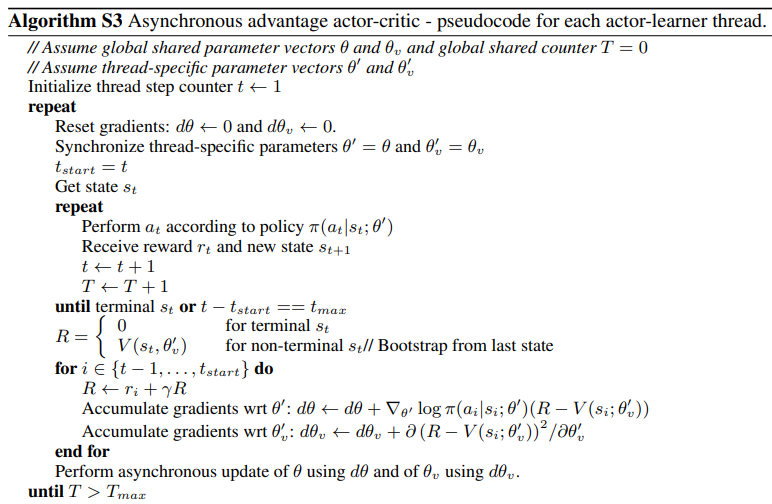

#### Replay Memory to store Training Data

In [ ]:
#----------------------------------------------------
# Accumulate the observation samples from playing the game in the replay memory
# so that they can be used as training data for the network.
#----------------------------------------------------
class Replay():
  # ----------------------------
  # Create the memory of the required sample size
  # ----------------------------
  def __init__(self, mem_sz):
    self.mem_sz = mem_sz
    self.mem = self._create()

  # ----------------------------
  # A simple list would have been fine, but we use a deque just because we had
  # used it in the DQN
  # ----------------------------
  def _create(self):
    mem = deque(maxlen=self.mem_sz)
    return mem

  # ----------------------------
  # Add a new observation sample to the memory
  # ----------------------------
  def add(self, action_prob, action_prob_dist, reward, value):
    self.mem.append((action_prob, action_prob_dist, reward, value))

  # ----------------------------
  # Clear all samples
  # ----------------------------
  def clear(self):
    self.mem.clear()

  # ----------------------------
  # Package the observations samples as a training batch
  # ----------------------------
  def get_batch(self):
    return np.array(self.mem)

#### Visualisation and Tracking

In [ ]:
from IPython import display as ipythondisplay
from PIL import Image

#----------------------------------------------------
# Visualise the playing of the game by generating a video of images
#----------------------------------------------------
class Visualise():
  def __init__(self, freq):
    # We process only every 'freq' episodes, and skip the rest, so we don't do
    # unnecessary video processing
    self.freq = freq
    self.frames = []
    self.track = False

  # ----------------------------
  # Initialise at the beginning of each episode
  # ----------------------------
  def begin_episode(self, i_episode):
    self.i_episode = i_episode
    self.track = self._track_episode()

  # ----------------------------
  # Generate the video at the end of the episode and clear our buffer for the
  # next episode
  # ----------------------------
  def end_episode(self):
    if (self.track):
      self._make_gif()
      self.frames = []

  # ----------------------------
  # Save an image frame in our buffer
  # ----------------------------
  def track_frame(self, frame):
    if (self.track):
      self.frames.append(Image.fromarray(frame))

  # ----------------------------
  # Returns True if this episode is to be processed
  # ----------------------------
  def _track_episode(self):
    return ((self.i_episode + 1) % self.freq == 0)

  # ----------------------------
  # Generate an animated GIF with the saved frames 
  # ----------------------------
  def _make_gif(self):
    i_episode = self.i_episode
    gif_file = f'game-{i_episode}.gif'
    # loop=0: loop forever, duration=1: play each frame for 1ms
    self.frames[0].save(gif_file, save_all=True, append_images=self.frames[1:], loop=0, duration=1)

    return gif_file

In [ ]:
#----------------------------------------------------
# Track stats on Tensorboard
#----------------------------------------------------
class Tracker():
  def __init__(self, name, freq):
    # Track only every 'freq' episodes and skip the rest
    self.freq = freq

    # Initialise the Tensorboard log file
    log_dir = "logs/" + "worker_" + name
    self.summary_writer = tf.summary.create_file_writer(log_dir)

  # ----------------------------
  # Track one statistic by writing it to Tensorboard
  # ----------------------------
  def track_stats(self, i_episode, tag, val):
    if ((i_episode + 1) % self.freq == 0):
      with self.summary_writer.as_default():
        tf.summary.scalar(tag, float(val), step=i_episode)

#### Worker Thread

In [ ]:
#----------------------------------------------------
# Worker thread, where most of the processing is done. Each Worker has its own copy
# of the game environment and Actor Critic network. In each cycle, it collects training 
# data by interacting with the environment and then uses that data to train its Actor Critic
# network. At the end of the cycle, it copies over its computed gradients to the Master 
# Actor Critic network. At the start of the next cycle, it updates itself with the
# Master's weights, thus getting improvements submitted by the other Workers as
# well.
#----------------------------------------------------
class Worker():
  # ----------------------------
  # Initialise a Worker object which will run in its own thread
  # ----------------------------
  def __init__(self, id, master_ac, app, frame_w, frame_h, max_episodes):
    # Hyperparameters
    self.gamma = 0.99
    self.eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0
    self.max_episodes = max_episodes
    self.max_steps = app.max_steps
    self.lr = app.lr
    self.alpha, self.beta = app.alpha, app.beta
    self.normalise_return = app.normalise_return
    self.use_final_value = app.use_final_value

    # Initialise visualisation and tracking
    self.name = str(id)
    track_freq = max_episodes//500 if max_episodes > 500 else 1
    vis_freq = max_episodes//5 if max_episodes > 5 else 1
    self.track = Tracker(self.name, track_freq)
    self.vis = Visualise(freq=vis_freq) if (id == 0) else None

    # Create an independent copy of the game environment for this worker
    self.env = Environment(frame_w, frame_h, self.vis)
    self.num_actions = len(self.env.actions)

    # Remember the Master Network and create an independent Local Network for this worker
    self.master_ac = master_ac
    self.ac = ActorCritic(frame_h, frame_w)
    self.model = self.ac.model
    self.huber_loss = keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=self.lr)

    # Create memory for collecting training data
    self.replay = Replay(mem_sz=self.max_steps)
    self.stacked_state = None
  
  # ----------------------------
  # Use our local Actor Critic network to predict an Action to take from the current
  # state. Also predict the V-Value of the current state.
  # 'stacked_state' is a stack of frames for the current state.
  # ----------------------------
  def get_action_value(self, stacked_state):
    # Actor model predicts the action probability distribution
    # Critic model predicts the V-value
    model = self.model
    action_prob_dist, critic_value = self.model(stacked_state)

    # Sample an action from action probability distribution
    action_idx = np.random.choice(self.num_actions, p=np.squeeze(action_prob_dist))
    action_prob = action_prob_dist[0, action_idx]

    return action_idx, action_prob, action_prob_dist, critic_value

  # ----------------------------
  # Given the actual observed Rewards from all the steps in the episode that we
  # took, and the predicted V-Value of the last state that we reached, compute the
  # discounted Returns of each step.
  # ----------------------------
  def _discounted_returns(self, rewards, final_value):
    if (not self.use_final_value):
      final_value = 0.0

    # Go through the observed rewards in reverse order
    returns = []
    # Use the predicted V-value of the last state to bootstrap the Returns
    discounted_return = final_value
    for r in rewards[::-1]:
      discounted_return = r + self.gamma * discounted_return
      returns.insert(0, discounted_return)

    # Normalize the Returns
    if (self.normalise_return):
      returns = np.array(returns)
      returns = (returns - np.mean(returns)) / (np.std(returns) + self.eps)
      returns = returns.tolist()

    return (returns)

  # ----------------------------
  # Print the weights of the Master and local networks for debugging
  # ----------------------------
  def _print_wgts(self, grads=[]):
    if (False):
      grad_mean = [tf.math.reduce_mean(grad) for grad in grads]
      master_wgt_mean = [tf.math.reduce_mean(wgt) for wgt in self.master_ac.model.get_weights()]
      worker_wgt_mean = [tf.math.reduce_mean(wgt) for wgt in self.model.get_weights()]
      #tf.print ("Len ", len(grad_mean), len(master_wgt_mean), len(worker_wgt_mean), grads[1].shape, self.master_ac.model.get_weights()[1].shape)
      tf.print ('Grad', self.name, grad_mean)
      tf.print ('Master', self.name, master_wgt_mean)
      tf.print ('Worker', self.name, worker_wgt_mean)

  # ----------------------------
  # Use the Action probabilities, V-values and discounted Returns of all the steps
  # that we took to compute the Total Actor Critic Loss
  # ----------------------------
  def _ac_loss(self, action_probs, action_prob_dists, values, returns, i_episode):
    # Calculating loss values to update our network
    actor_losses = []
    critic_losses = []
    entropy_vals = []

    # At each step in the trajectory, the critic estimated that we would get a
    # total reward = `value` in the future. We took an action with probability
    # of `action_prob` and ended up receiving a total reward = `ret`.

    # The actor must be updated so that it predicts an action that leads to
    # high rewards (compared to critic's estimate) with high probability.

    # The critic must be updated so that it predicts a better estimate of
    # the future 'value'

    for action_prob, action_prob_dist, value, ret in zip(action_probs, action_prob_dists, values, returns):
      # Compute the advantage as the difference between the actual observed Return and
      # predicted Value. Actor Loss is negative log of action probability multiplied by
      # the advantage.
      advantage = ret - value
      actor_loss = -tf.math.log(action_prob) * advantage
      actor_losses.append(actor_loss)

      # Critic Loss is Mean Square Error between the observed return and the predicted
      # Value. Huber Loss is equivalent but is less sensitive to outliers.
      critic_loss = self.huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
      critic_losses.append(critic_loss)

      # Entropy is higher when the action probabilities for different actions are similar.
      # Since we take the negative, reducing Loss means increasing Entropy. This encourages
      # exploration in the initial stages.
      entropy = tf.reduce_sum(-tf.math.log(action_prob_dist) * action_prob_dist)
      entropy_vals.append(entropy)
      if (False): tf.print(ret, advantage, actor_loss, critic_loss, entropy)

    # Total actor-critic loss
    loss_value = sum(actor_losses) + self.alpha * sum(critic_losses) - self.beta * sum(entropy_vals)
    self.track.track_stats(i_episode, 'Loss/Total Loss', loss_value)
    if (False): tf.print(float(loss_value), float(sum(actor_losses)), float(sum(critic_losses)))
    return loss_value

  # ----------------------------
  # Use the training data that we collected during the episode to train the model. We compute
  # loss and gradients using our local network, and then copy those gradients over to the
  # master network.
  # ----------------------------
  def _train(self, batch, final_value, tape, i_episode):
    # Get saved training data
    action_probs, action_prob_dists, rewards, values = batch.transpose()

    # Compute Discounted Returns and Loss
    returns = self._discounted_returns(rewards, final_value)
    loss_value = self._ac_loss(action_probs, action_prob_dists, values, returns, i_episode)

    # Compute gradients with the Loss, and use them to update the Master weights
    grads = tape.gradient(loss_value, self.model.trainable_variables)
    # !!!!!!!!! This should be a method on some other class. Also can have a single optimiser
    # for all workers
    self.optimizer.apply_gradients(zip(grads, self.master_ac.model.trainable_variables))
    self._print_wgts(grads)

  # ----------------------------
  # Run one cycle of N timesteps, as part of an episode, to collect training data. We return
  # a flag indicating whether the episode was completed, along with the last state and the
  # V-value of that last state. When we are called for the next cycle, and if the episode
  # wasn't completed, we resume the episode from the last state.
  # ----------------------------
  def _run_episode_cycle(self, initial_state):
    cycle_rewards = 0 # Add all rewards received in the cycle
    stacked_state = initial_state

    # Loop for N (ie. max_steps) timesteps. If the episode completes before that we
    # break out of the loop.
    for timestep in range(self.max_steps):
      # Take an action in the environment and observe the rewards and next state
      action_idx, action_prob, action_prob_dist, value = self.get_action_value(stacked_state)
      action = self.env.actions[action_idx]
      next_stacked_state, reward, done = self.env.step(action)
      cycle_rewards += reward

      # Package a training sample and save it
      self.replay.add(action_prob, action_prob_dist, reward, value)
      if (False): tf.print (stacked_state, action, action_prob, action_prob_dist, reward, value)

      if (done):
        # Episode has ended. Clear our next state and break out of the loop
        stacked_state = None
        break
      else:
        # Keep looping
        stacked_state = next_stacked_state

    # Check if we completed the cycle after N steps, or because the episode ended
    if (done):
      # Episode has ended, we reached a terminal state
      final_value = 0.0              
    else:
      # Episode in progress, but we completed 'max_steps'
      # Get the V-value of the last state reached
      _, _, _, final_value = self.get_action_value(stacked_state)

    return (stacked_state, final_value, cycle_rewards)

  # ----------------------------
  # This is the primary entrypoint to execute the Worker thread and fully train the
  # Worker. It is invoked only once per Worker and runs till we complete the given 
  # number of episodes. It gathers training data as it executes episodes with the 
  # environment, and then uses that data to train its model.
  # ----------------------------
  def process(self, coord):
    i_episode, i_cycle = 0, 0
    moving_avg_rewards, episode_rewards = 0, 0

    # Keep looping till we complete the given number of episodes, or if we are
    # asked to terminate by the main Coordinator
    with coord.stop_on_exception():
      while (i_episode < self.max_episodes) and (not coord.should_stop()):
        # We reach here in either of two situations:
        #  1) The previous episode ended and we need to start a new episode.
        #  2) We completed 'max_steps' in the previous cycle and now need to continue the
        #     the same episode from that point on.

        # Copy the Master network's weights to our local network
        self.ac.copy_weights(self.master_ac)
        self._print_wgts()

        stacked_state = self.stacked_state
        # Check if this is the start of a new episode ie. case #1 above
        if (stacked_state is None):
          # Initialise at start of new episode
          episode_rewards = 0
          self.replay.clear()

          # Get the initial state at the start of the episode
          stacked_state = self.env.first_step(i_episode)

        # Run one cycle of N steps as part of the episode, gather training data and
        # train the model
        final_value = None
        with tf.GradientTape() as tape:
          # Run a cycle and capture a batch of training data.
          self.stacked_state, final_value, cycle_rewards = self._run_episode_cycle(stacked_state)
          episode_rewards += cycle_rewards  # Total rewards for the episode
          episode_done = (self.stacked_state is None) # Has episode ended?
          if (False): print ('Rewards', cycle_rewards, episode_rewards, moving_avg_rewards, episode_done)

          # Train the network with the training data batch
          batch = self.replay.get_batch()
          self._train(batch, final_value, tape, i_cycle)

          i_cycle += 1
          #sleep(1.5)
        
        # Track statistics if the episode has ended
        if (self.stacked_state is None):
          # Moving average of per-episode rewards
          moving_avg_rewards = episode_rewards * 0.01 + moving_avg_rewards * 0.99
          self.track.track_stats(i_episode, 'Reward/Episode', episode_rewards)
          self.track.track_stats(i_episode, 'Reward/Running', moving_avg_rewards)

          # Print out some ongoing updates every few episodes
          freq = self.max_episodes // 20 if self.max_episodes > 20 else 1
          if ((i_episode + 1) % freq == 0):
            print ('Worker', self.name, i_episode, i_cycle, episode_rewards, moving_avg_rewards)
            # Save our local model weights. They are one episode behind as they don't have the 
            # latest master updated weights from the current episode but that's Ok.
            if (self.name == '0'): self.model.save_weights("ckpt")

          i_episode += 1


In [ ]:

    # !!!!!!!!!
    # Do we need a loop inside ac_loss(), or can it be vectorised?
    # NO Use a shared common optimiser
    # Should any of Worker's methods be moved to Actor Critic?
    # Just use stacked_state instead of self.stacked_state
    # YES Confirm calcs of final_value and entropy
    # YES Normalise Return calcs?
    # YES Stop after N episodes 
    # ?? Use action_dist = torch.distribution.Categorical(logits) and then action = action_dist.sample()

    # Stop when solved based on some criterion, as in Keras tutorial
    # Neaten Model code
    # DONE Make state a tensor instead of numpy array
    # DONE Save model weights after every N episodes
    # DONE Test with multi-threads
    # DONE Check if model weights are being updated at each iteration
    # DONE Try with a different game - CartPole or Vizdoom
    #https://keras.io/examples/rl/actor_critic_cartpole/
    #https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic
    #https://blog.tensorflow.org/2018/07/deep-reinforcement-learning-keras-eager-execution.html
    #https://pylessons.com/A3C-reinforcement-learning/
    # https://github.com/shalabhsingh/A3C_Keras_FlappyBird/blob/master/train_network.py
    #TEMP A3C Doom https://colab.research.google.com/drive/1bbIoN0xkqs5Y85EXNVyh6gYYoc_Wf1Qu

#### Main Program

In [ ]:
#----------------------------------------------------
# Main function to create the Master Actor Critic, and launch all the Worker
# threads. It then waits for all workers to finish. It doesn't do much else, as
# all of the real processing happens in the Workers.
#----------------------------------------------------
def main(app, max_episodes, num_workers=multiprocessing.cpu_count(), load=False):
  # Create Master Actor Critic network
  frame_w, frame_h = 80, 80
  master_ac = ActorCritic(frame_h, frame_w)
  if (load): master_ac.model.load_weights("ckpt")

  # By default, num_workers is the number of available CPU threads
  print ('num workers', num_workers)
  workers = []
  # Create Workers
  for id in range(num_workers):
    workers.append(Worker(id, master_ac, app, frame_w, frame_h, max_episodes))

  try:
    # TF Coordinator helps us wait for all threads to terminate
    coord = tf.train.Coordinator()
    # Start a separate thread for each Worker, passing the Coordinator to each of them
    threads = []
    for worker in workers:
      # Run Worker.process() function in each thread
      thread_fn = partial(worker.process, coord)
      t = threading.Thread(target=thread_fn)
      t.start()
      sleep(0.5)
      threads.append(t)

    # Wait for all the threads to terminate, give them 10s grace period
    coord.join(threads, stop_grace_period_secs=100000)
  except RuntimeError:
    # one of the threads took more than 10s to stop after request_stop() was called.
    pass
  except Exception:
    # exception that was passed to coord.request_stop()
    coord.request_stop(exception)
  finally:
    # Forcibly stop all threads
    coord.request_stop()
    coord.join(threads)

#### Train the Actor Critic

In [ ]:
class App():
  def __init__(self, name):
    self.name = name
    self._get_params()

  def _get_params(self):
    if (self.name == "cartpole"):
      self.max_steps = 10000
      self.lr = 0.01
      self.alpha, self.beta = 1.0, 0.0
      self.normalise_return = True
      self.use_final_value = False

    elif (self.name == "flappybird"):
      self.max_steps = 128
      self.lr = 0.0007
      self.alpha, self.beta = 0.5, 0.01
      self.normalise_return = False
      self.use_final_value = False

    else:
      self.max_steps = 24
      self.lr = 0.0007
      self.alpha, self.beta = 0.5, 0.01
      self.normalise_return = False
      self.use_final_value = True

In [ ]:
# Clear any Tensorboard logs from previous runs
!rm -rf ./logs/
!rm game-*.gif
!ls

In [ ]:
%%time
main(App('flappybird'), max_episodes=10000, num_workers=1)
#main(App('flappybird'), max_episodes=10000)
#main(App('cartpole'), max_episodes=5, load=True)

In [ ]:
# Visualise animated GIF video of the game
import tensorflow_docs.vis.embed as embed
gif_file = "game-4999.gif"
embed.embed_file(gif_file)

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=logs

Results

In [ ]:
# self.max_steps = 128
# self.lr = 0.0007
# self.alpha, self.beta = 1.0, 0.0
# self.normalise_return = False
# self.use_final_value = False

num workers 1
Worker 0 999 1000 3.799999999999999 3.7998202767096134
Worker 0 1999 2000 3.799999999999999 3.7446654270340467
Worker 0 2999 3000 3.9999999999999982 3.9214650587576227
Worker 0 3999 4000 3.799999999999999 3.8095332701373894
Worker 0 4999 5000 5.899999999999995 5.273582842610904
Worker 0 5999 6000 8.299999999999986 7.512271090290922
Worker 0 6999 7004 8.299999999999986 8.62965740231923
Worker 0 7999 8015 9.399999999999983 8.77939999150274
Worker 0 8999 9026 8.299999999999986 9.356523464471765
Worker 0 9999 10048 8.299999999999986 9.741306781250543
Worker 0 10999 11068 12.999999999999973 9.765775050441666
Worker 0 11999 12097 8.299999999999986 9.910704762742649

num workers 1
thread Thread-4 0 1 3.799999999999999 0.03799999999999999
thread Thread-4 500 501 3.799999999999999 3.7752818427944144
thread Thread-4 1000 1001 3.799999999999999 3.7998375897672183
thread Thread-4 1500 1501 3.799999999999999 3.7999989328862966
thread Thread-4 2000 2001 3.799999999999999 3.799999992988526
thread Thread-4 2500 2501 3.799999999999999 3.799999999953909
thread Thread-4 3000 3001 3.799999999999999 3.7999999999996747
thread Thread-4 3500 3501 3.799999999999999 3.799999999999956
thread Thread-4 4000 4001 3.799999999999999 3.799999999999956
thread Thread-4 4500 4501 3.799999999999999 3.799999999999956
thread Thread-4 5000 5001 3.799999999999999 3.8005749868566414
thread Thread-4 5500 5501 6.299999999999994 3.8500357170773785
thread Thread-4 6000 6001 3.799999999999999 3.9887290496544887
thread Thread-4 6500 6501 3.799999999999999 3.9230835678724483
thread Thread-4 7000 7001 3.799999999999999 4.1297616844278195
thread Thread-4 7500 7502 3.799999999999999 4.9763892716108336
thread Thread-4 8000 8002 5.899999999999995 5.999368146638289
thread Thread-4 8500 8503 9.399999999999983 7.111827411956756
thread Thread-4 9000 9003 8.299999999999986 7.80978865979413
thread Thread-4 9500 9506 13.199999999999973 8.22554616246753
CPU times: user 5h 2min 34s, sys: 4h 40min 46s, total: 9h 43min 21s
Wall time: 6h 27min 17s

# self.max_steps = 128
# self.lr = 0.0007
# self.alpha, self.beta = 1.0, 0.0
# self.normalise_return = False
# self.use_final_value = False
# Two Threads

num workers 2
Worker 0 499 500 3.799999999999999 3.7750321644388025
Worker 1 499 500 3.799999999999999 3.7750321644388025
Worker 0 999 1000 3.799999999999999 3.799835949259817
Worker 1 999 1000 3.799999999999999 3.799835949259817
Worker 1 1499 1500 3.799999999999999 3.7999989221073704
Worker 0 1499 1500 3.799999999999999 3.7999989221073704
Worker 1 1999 2000 3.799999999999999 3.7999999929177033
Worker 0 1999 2000 3.799999999999999 3.7999999929177033
Worker 0 2499 2500 3.799999999999999 3.7999999999534437
Worker 1 2499 2500 3.799999999999999 3.7999999999534437
Worker 0 2999 3000 3.799999999999999 3.799151286012184
Worker 1 2999 3000 3.799999999999999 3.799052074471581
Worker 0 3499 3500 3.799999999999999 3.799994423539114
Worker 1 3499 3500 3.799999999999999 3.7999937716713683
Worker 1 3999 4000 3.799999999999999 3.7999999590768505
Worker 0 3999 4000 3.799999999999999 3.7999999633599364
Worker 1 4499 4500 3.799999999999999 3.746381552469514
Worker 0 4499 4500 3.799999999999999 3.860964903446617
Worker 1 4999 5000 3.799999999999999 4.017335161939327
Worker 0 4999 5000 3.799999999999999 4.013852048676002
Worker 1 5499 5500 8.299999999999986 4.660854566534965
Worker 0 5499 5500 5.999999999999995 4.6044596546725955
Worker 1 5999 6000 8.299999999999986 7.3507510687083375
Worker 0 5999 6001 6.5999999999999925 7.416069783152597
Worker 1 6499 6500 9.199999999999983 8.409779671791474
Worker 0 6499 6501 9.199999999999983 8.352567438475218
Worker 0 6999 7001 8.799999999999985 7.55958697092627
Worker 1 6999 7000 8.799999999999985 7.653191270077733
Worker 0 7499 7501 8.299999999999986 8.608614947020895
Worker 1 7499 7500 9.199999999999983 8.649329703364382
Worker 0 7999 8001 9.199999999999983 8.611973907912635
Worker 1 7999 8000 8.899999999999984 8.698918272648045
Worker 0 8499 8501 6.199999999999994 8.7494439046108
Worker 1 8499 8500 8.799999999999985 8.828638080065518
Worker 0 8999 9001 9.099999999999984 8.857549490649255
Worker 1 8999 9000 8.299999999999986 8.75934828510038
Worker 0 9499 9501 8.399999999999986 8.835382199558484
Worker 1 9499 9500 8.299999999999986 8.890823507938896
Worker 0 9999 10001 8.899999999999984 8.853732712024842
Worker 1 9999 10000 9.099999999999984 8.928857220850828
CPU times: user 9h 22min, sys: 6h 31min 53s, total: 15h 53min 53s
Wall time: 9h 7min 6s